In [1]:
%matplotlib inline
from sensor_data_analysis_api import *
from sklearn.metrics import mean_squared_error
import sys
import os

In [2]:
# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

blockPrint()

### API: CompressWithPCA

**CompressWithPCA is the API that performs PCA on the data frame and plots the original and reconstructed for template.**

1. Takes the data frame as input
2. Performs PCA, transforms and reconstructs the data frame with the number of components specified
3. filters the data frame based on date range
4. selects the required template from original and reconstructed
5. returns the data frames

**Observations**

1. Though the 95% of variance is explained with only 4 major components, the Zone temperature and supplt air flow has optimal reconstruction with 9 components

In [5]:
room = 'Rm-4226'
dataDF = get_signal_dataframe(room, mean_type="quarter_hour" , use_weather_data=False)

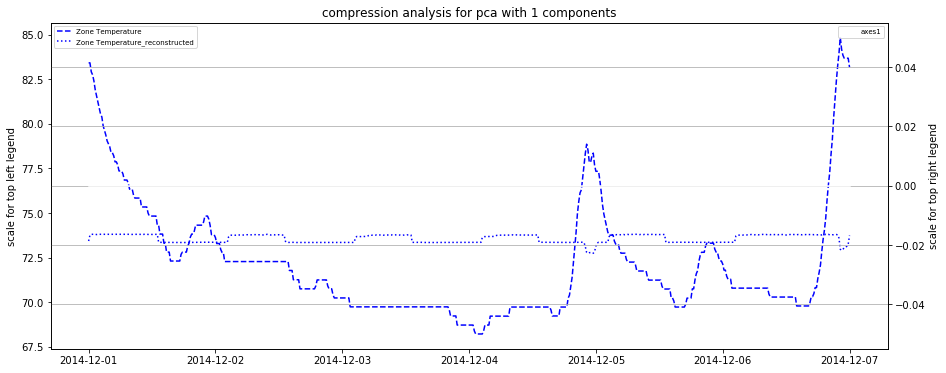

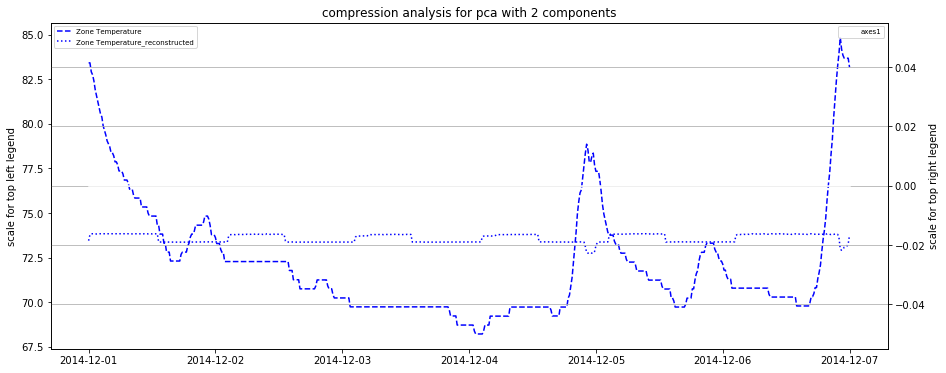

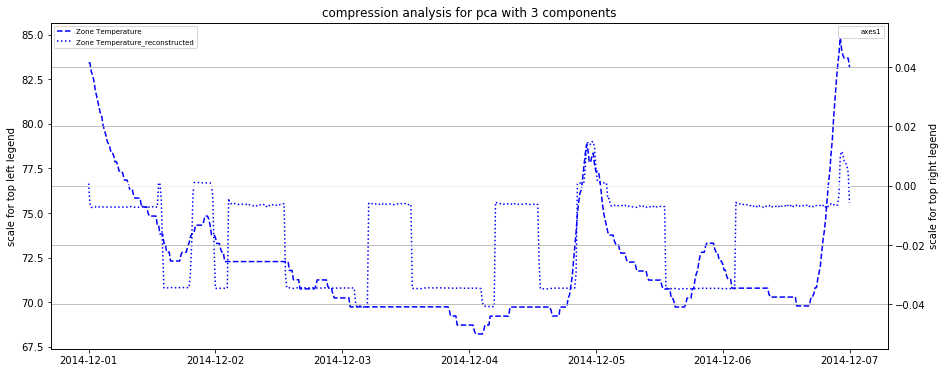

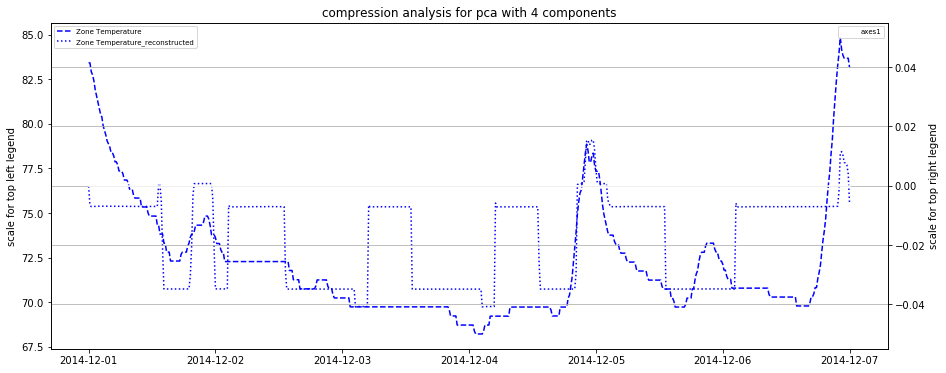

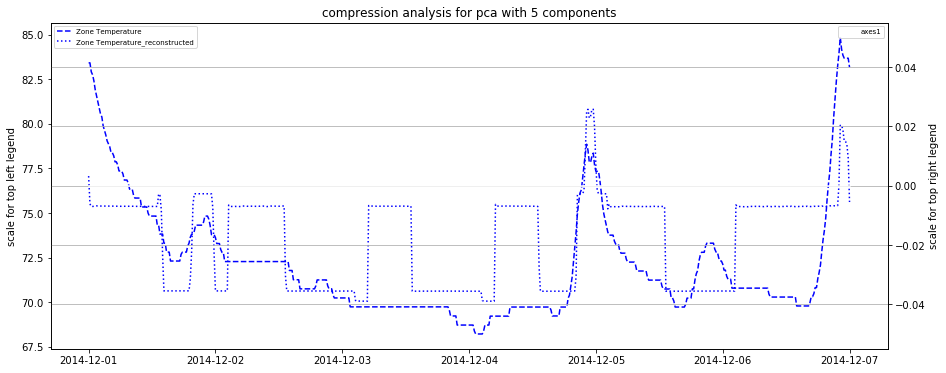

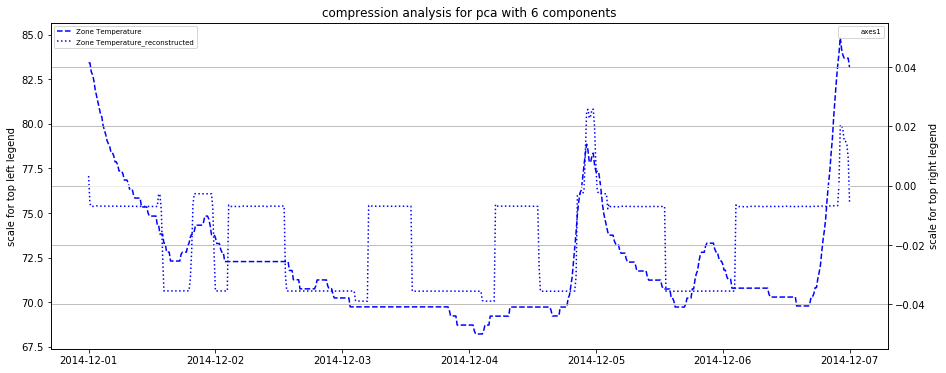

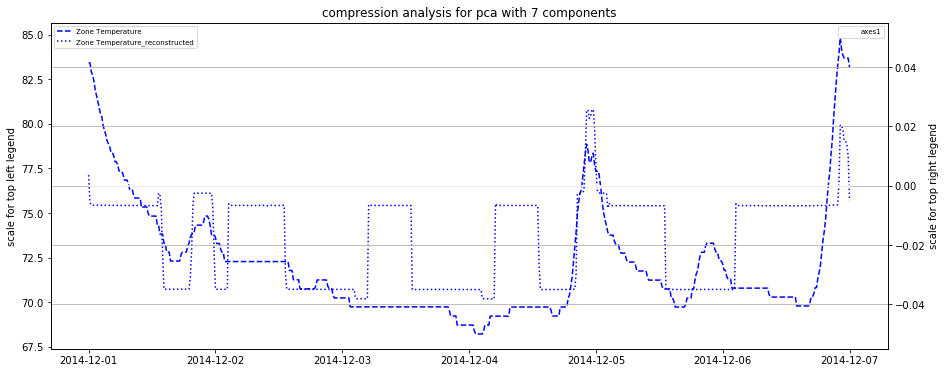

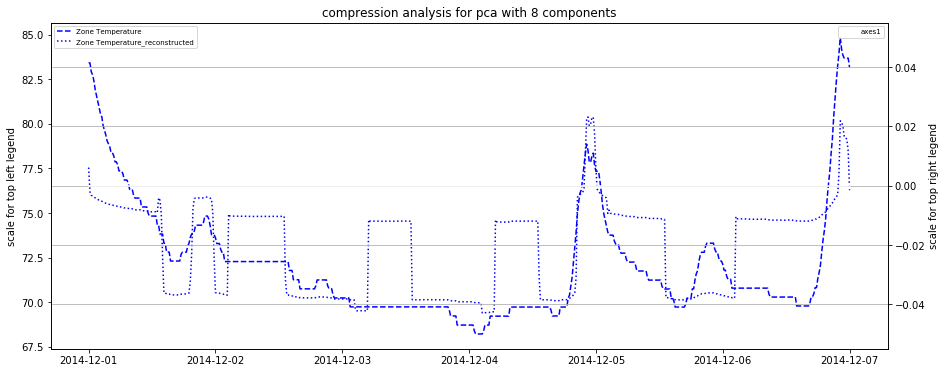

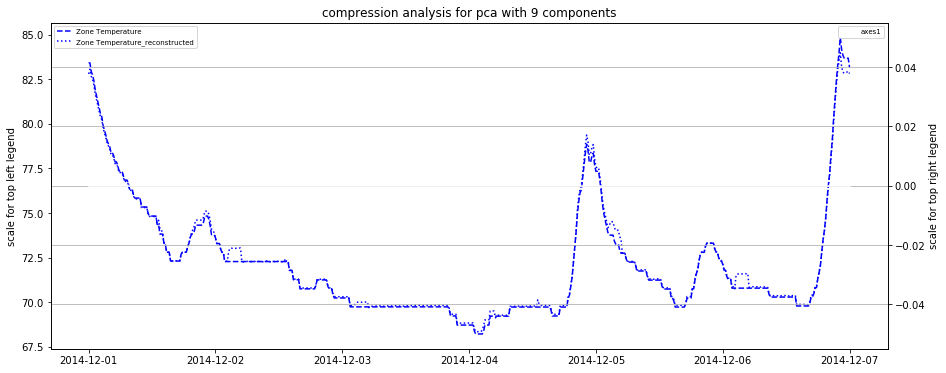

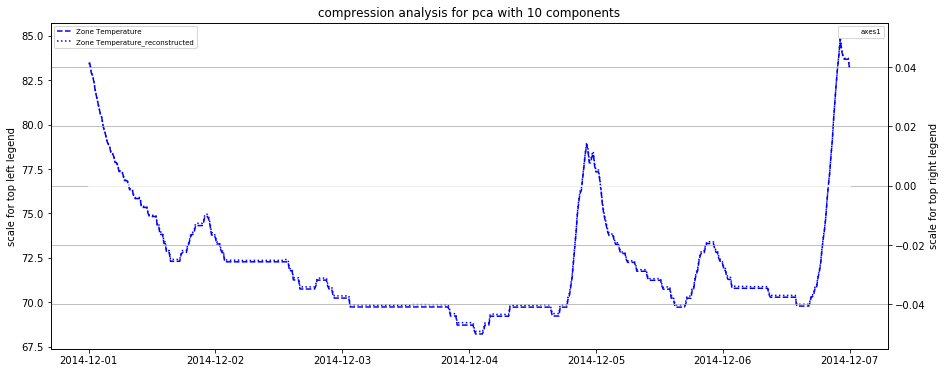

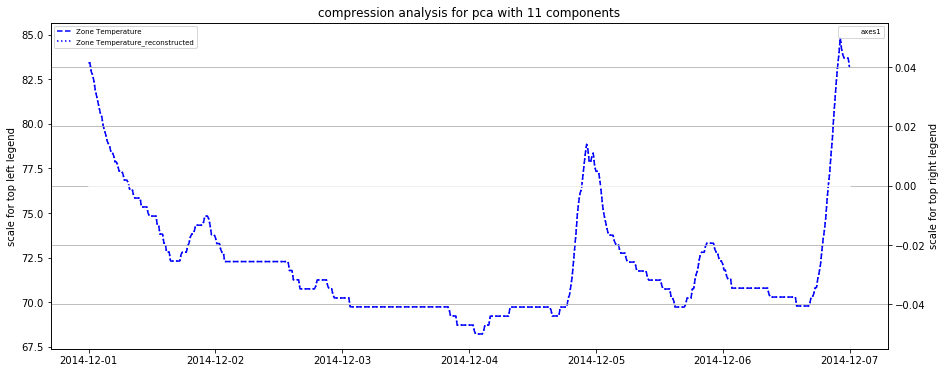

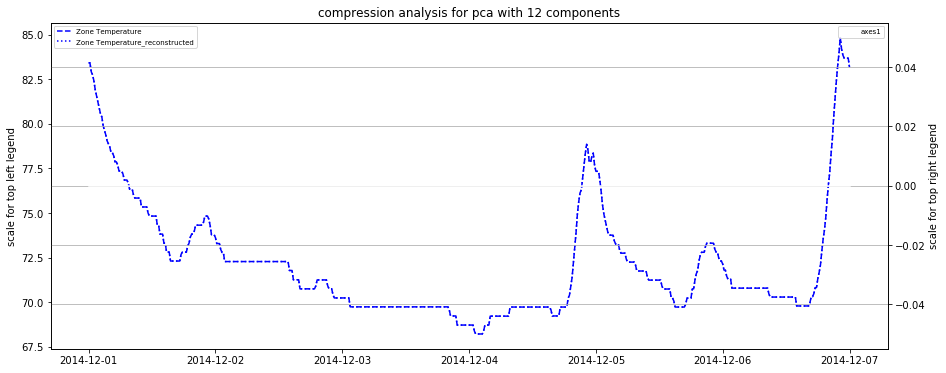

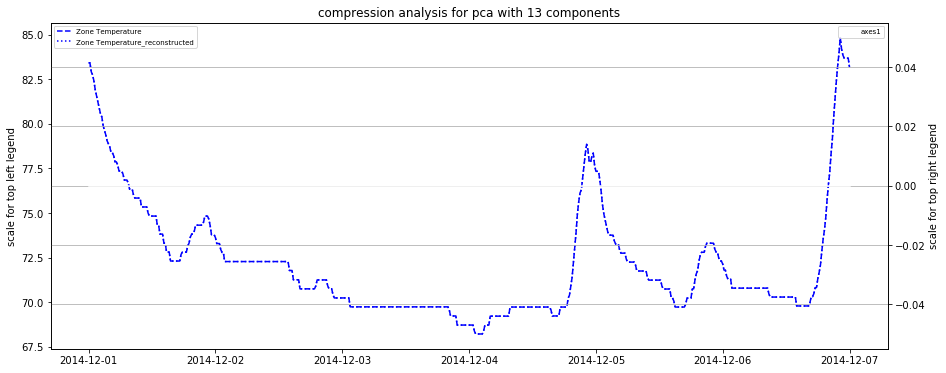

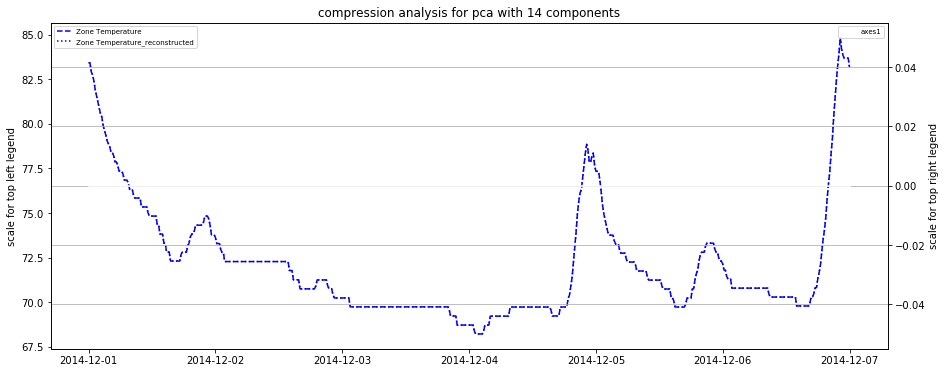

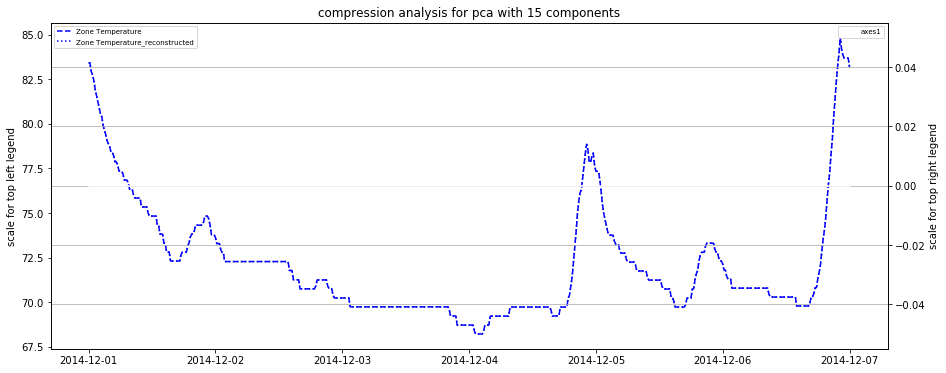

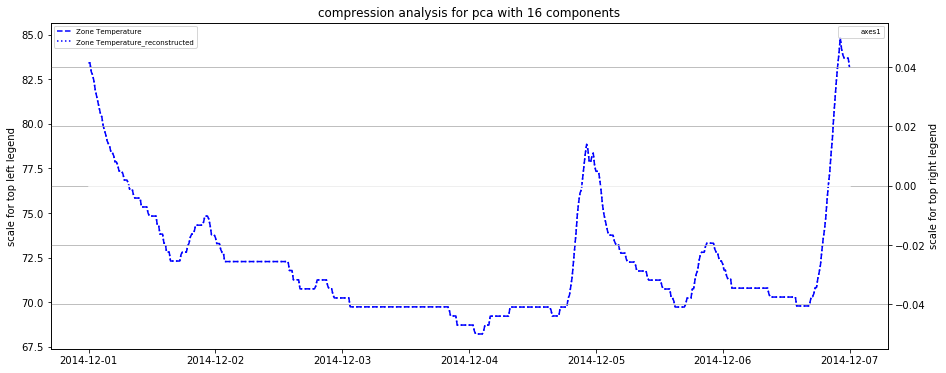

In [40]:
for n_components in range(1,17): 
    [dfs, plotTemplates, compressed] = CompressWithPCA(dataDF, stTime='2014-12-01', enTime='2014-12-07', n_components = n_components)
    plotResults(dfs, plotTemplates, method='pca with %d components'%n_components)

### API for running multiple models on several rooms and signals

- Takes in rooms, signals, start time and end time
- Runs piecewise linear, piecewise constant, PCA with 4, 7 and 9 components
- calculates the RMSE of original and reconstructed signals.

In [30]:
def AnalyzeModels(rooms, signals, stTime, enTime):
    df_list = []
    
    for room in rooms:
        dataDF = get_signal_dataframe(room, mean_type="quarter_hour" , use_weather_data=False)
        for signal in signals:
            # PCA
            for n_components in range(1,17): 
                method = 'PCA_%d'%n_components
                [dfs, plotTemplates, compressed] = CompressWithPCA(dataDF, stTime, enTime, n_components = n_components)
                rmse = mean_squared_error(dfs[0]['values'][dfs[1].notnull()], dfs[1][dfs[1].notnull()])
                d = {
                    'room' : room, 'model' : method, 'rmse' : rmse, 'signal' : signal, 'start_time' : stTime, 'end_time' : enTime,
                    'original_size' : dataDF.memory_usage().sum() - dataDF.memory_usage()['Index'],
                    'compressed_size' : compressed[0].nbytes
                }
                df_list.append(pd.DataFrame(d, index=[0]))

    return pd.concat(df_list, ignore_index=True)

In [31]:
#rooms = ['Rm-4226']
rooms = ['Rm-4226', 'Rm-3114']
signals = ['Zone Temperature', 'Supply Airflow']
df_result = AnalyzeModels(rooms, signals, stTime='2014-12-01', enTime='2014-12-07')

### Results of piecewise linear, piece wise constant, PCA for rooms 4226 and 3114

- RMSE for piecewise linear for supply airflow is higher because of larger range of values and non standardisation
- For room 4226, 9 components explain the Zone temperature and Supply airflow.
- But for room 3114, even 4 components the RMSE is lesser.

In [42]:
color_map = {'piecewise_linear' : 'red', 'piecewise_constant' : 'green', 'PCA_16' : 'aqua', 'PCA_9' : 'blue',
             'PCA_7' : 'orange', 'PCA_4' : 'violet'}

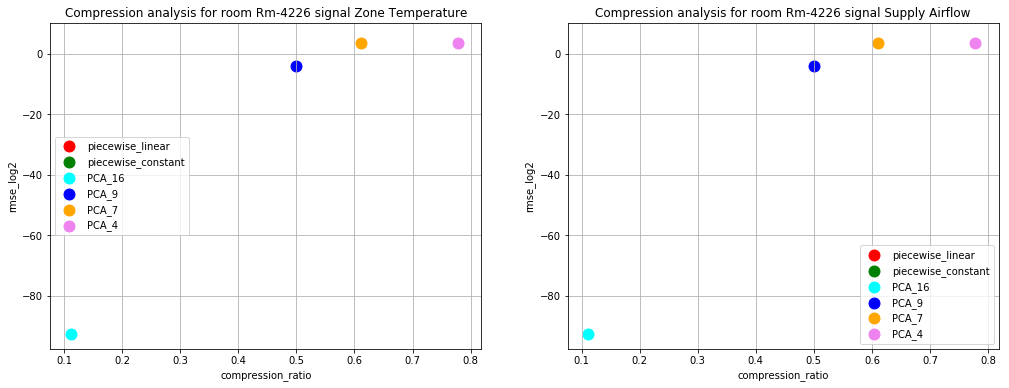

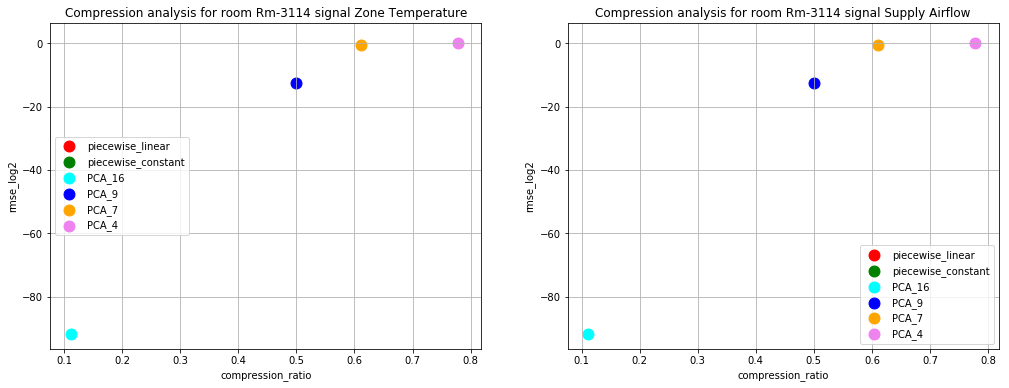

In [43]:
df_result['compression_ratio'] = (df_result.original_size - df_result.compressed_size) / df_result.original_size
df_result['rmse_log'] = np.log2(df_result.rmse)
models = ['piecewise_linear', 'piecewise_constant', 'PCA_16', 'PCA_9','PCA_7', 'PCA_4']
for room in df_result.room.unique():
    fig, axs = plt.subplots(1, 2, figsize=(17, 6))
    for ax, signal in zip(axs, df_result.signal.unique()):
        ax.set_title('Compression analysis for room %s signal %s'%(room, signal))
        ax.set_xlabel('compression_ratio')
        ax.set_ylabel('rmse_log2')
        ax.grid(True)
        #for model in df_result.model.unique():
        for model in models:
            x = df_result[(df_result.signal == signal) & (df_result.model == model) & (df_result.room == room)].compression_ratio
            y = df_result[(df_result.signal == signal) & (df_result.model == model) & (df_result.room == room)].rmse_log
            ax.scatter(x, y, c=color_map[model], s=120, label=model)

    axs[0].legend(loc='center left')
    axs[1].legend(loc='lower right')

In [44]:
df_result[['room', 'model', 'rmse', 'compression_ratio', 'signal']].set_index(['room', 'signal', 'model'])

rmse  compression_ratio
room    signal           model                                  
Rm-4226 Zone Temperature PCA_1   1.270685e+01           0.944444
                         PCA_2   1.278752e+01           0.888889
                         PCA_3   1.140785e+01           0.833333
                         PCA_4   1.107488e+01           0.777778
                         PCA_5   1.094667e+01           0.722222
                         PCA_6   1.094314e+01           0.666667
                         PCA_7   1.106108e+01           0.611111
                         PCA_8   8.288340e+00           0.555556
                         PCA_9   5.439388e-02           0.500000
                         PCA_10  1.104298e-02           0.444444
                         PCA_11  4.466608e-07           0.388889
                         PCA_12  7.235322e-08           0.333333
                         PCA_13  4.143198e-09           0.277778
                         PCA_14  1.336989e-28           0.222222
                         PCA_15  1.336989e-28           0.166667
                         PCA_16  1.343989e-28           0.111111
        Supply Airflow   PCA_1   1.270685e+01           0.944444
                         PCA_2   1.278752e+01           0.888889
                         PCA_3   1.140785e+01           0.833333
                         PCA_4   1.107488e+01           0.777778
                         PCA_5   1.094667e+01           0.722222
                         PCA_6   1.094314e+01           0.666667
                         PCA_7   1.106108e+01           0.611111
                         PCA_8   8.288340e+00           0.555556
                         PCA_9   5.439388e-02           0.500000
                         PCA_10  1.104298e-02           0.444444
                         PCA_11  4.466608e-07           0.388889
                         PCA_12  7.235322e-08           0.333333
                         PCA_13  4.143198e-09           0.277778
                         PCA_14  1.336989e-28           0.222222
...                                       ...                ...
Rm-3114 Zone Temperature PCA_3   1.084546e+00           0.833333
                         PCA_4   1.035827e+00           0.777778
                         PCA_5   1.209757e+00           0.722222
                         PCA_6   1.264631e+00           0.666667
                         PCA_7   6.566040e-01           0.611111
                         PCA_8   1.574652e-04           0.555556
                         PCA_9   1.552908e-04           0.500000
                         PCA_10  1.275822e-06           0.444444
                         PCA_11  5.910673e-07           0.388889
                         PCA_12  6.732203e-09           0.333333
                         PCA_13  2.372981e-28           0.277778
                         PCA_14  2.372981e-28           0.222222
                         PCA_15  2.372981e-28           0.166667
                         PCA_16  2.351981e-28           0.111111
        Supply Airflow   PCA_1   1.113188e+00           0.944444
                         PCA_2   1.080529e+00           0.888889
                         PCA_3   1.084546e+00           0.833333
                         PCA_4   1.035827e+00           0.777778
                         PCA_5   1.209757e+00           0.722222
                         PCA_6   1.264631e+00           0.666667
                         PCA_7   6.566040e-01           0.611111
                         PCA_8   1.574652e-04           0.555556
                         PCA_9   1.552908e-04           0.500000
                         PCA_10  1.275822e-06           0.444444
                         PCA_11  5.910673e-07           0.388889
                         PCA_12  6.732203e-09           0.333333
                         PCA_13  2.372981e-28           0.277778
                         PCA_14  2.372981e-28           0.222222
                         PCA_15  2.372981e-28           0.166667
           